https://www.tensorflow.org/guide/mixed_precision

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-12-30 16:06:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-12-30 16:06:30 (111 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [2]:
import tensorflow as tf
from helper_functions import plot_loss_curves, compare_historys

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-edb1a11f-36a9-dca3-5465-5f37d49ca34a)


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# pip install tensorflow-datasets

In [6]:
# Use tensorflow datasets to download data

# https://www.tensorflow.org/datasets/catalog/food101

import tensorflow_datasets as tfds

In [7]:
dataset_list = tfds.list_builders() # Get all available datasets in TFDS
print("food101" in dataset_list)

True


In [8]:
(train_data, val_data), ds_info = tfds.load(
    "food101",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    data_dir="/content/drive/MyDrive/Colab Notebooks/data"
)


In [9]:
# tf.data.Dataset.save(train_data, "/content/drive/MyDrive/tensorflow/data/food101_train")

In [10]:
# tf.data.Dataset.save(val_data, "/content/drive/MyDrive/tensorflow/data/food101_val")

In [11]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [12]:
import tensorflow as tf

In [13]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [14]:
len(train_data), len(val_data)

(75750, 25250)

In [15]:
print(train_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


## Exploring the Food101 data from tensorfloe datasets

To be come one with the dataset we want to find out
1. Class names
2. The shape of the input data (image tensors)
3. The datatype of input data
4. What the labels look like (e.g are they one-hot encoded or label encoded)
5. Do the labels match up class names
6. Visualize some data

In [16]:
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [17]:
# Output info about training sample

for image, label in train_one_sample:
  print(f"""
  Image shape : {image.shape}
  Image datatype : {image.dtype}
  Target class from food 101 (tensor form) : {label}
  Class name (str form) : {class_names[label.numpy()]}
  """)


  Image shape : (512, 512, 3)
  Image datatype : <dtype: 'uint8'>
  Target class from food 101 (tensor form) : 56
  Class name (str form) : huevos_rancheros
  


In [18]:
# What does our image tensors look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [19]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

In [20]:
#Plot an image
import matplotlib.pyplot as plt

def plot_a_random_image(dataset):

  for image, label in dataset.take(1):
    shape = image.shape
    label = class_names[label.numpy()]


  plt.imshow(image)
  plt.title(f"{label} / {shape}")
  plt.axis("off")
  plt.show();


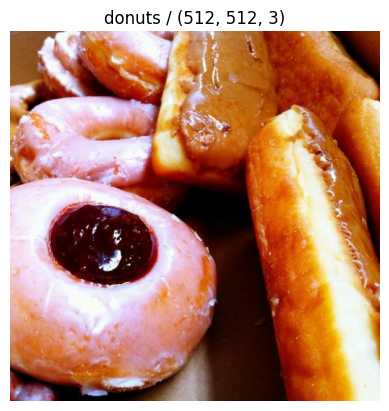

In [21]:
plot_a_random_image(train_data)

In [22]:
# Preprocess images

"""
1. We need images in uint8 dtype
2. comprised of all different size tensors (different sizzed images)
3. Not scaled (pixels should be between 0-1)


Models prefers
1. Data in float32 (or for mixed size float32 and float16)
2. scaled tensor / normalized tensors
"""

def preprocess_img(image,
                   label,
                   image_shape=224
                   ):
  """
  Convert image dtype from uint8 to float32
  And reshapa image to (img_shape, img_shape, channels=3)
  """

  image = tf.image.resize(image, [image_shape, image_shape])
  image = tf.ensure_shape(image, [image_shape, image_shape, 3])
  return tf.cast(image, tf.float32), label

In [23]:
image_preprocessed = preprocess_img(image, label)

In [24]:
image_preprocessed[0].dtype, image_preprocessed[0].shape

(tf.float32, TensorShape([224, 224, 3]))

In [25]:
image.dtype, image.shape

(tf.uint8, TensorShape([512, 512, 3]))

In [26]:
# Implement preprocess_img for all dataset and create batches

train_data = (train_data
            .map(
                map_func=preprocess_img,
                num_parallel_calls=tf.data.AUTOTUNE) # Very important for performance
)
train_ds = (train_data
            .shuffle(buffer_size=1000) # We can do len(data) but we may be out of memory if data is too large
            .batch(batch_size=32)
            .prefetch(buffer_size=tf.data.AUTOTUNE) # Very important for performance
)


test_data = (val_data
             .map(
                 map_func=preprocess_img,
                 num_parallel_calls=tf.data.AUTOTUNE) # Very important for performance
)

test_ds = (test_data
            # .shuffle(buffer_size=1000) # We can do len(data) but we may be out of memory if data is too large # We do not need this for validation dataset
            .batch(batch_size=32)
            .prefetch(buffer_size=tf.data.AUTOTUNE) # Very important for performance
)

In [27]:
len(train_ds), len(test_ds)

(2368, 790)

In [28]:
train_ds, test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [29]:
# Creating modelling callbacks
# 1. Tensorboard
# 2. Model Checkpointing
# 3. Early Stopping

In [30]:
import keras
import datetime
import os

# Create a tensorboard callback
def create_model_checkpoint_callback(dir_name, experiment_name):
    checkpoint_path = os.path.join(
        dir_name,
        experiment_name,
        "ckpt-epoch{epoch:02d}.weights.h5"
    )

    return keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor="vall_loss",
        save_best_only=True,
        save_weights_only=True,
        save_freq='epoch',
        verbose=0
    )


def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = os.path.join(
        dir_name,
        experiment_name,
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    )

    return keras.callbacks.TensorBoard(
        log_dir=log_dir
    )


# Create model checkpoint callback
checkpoint_path = "logs/model_checkpoints/"
model_checkpoint = create_model_checkpoint_callback(
    dir_name=checkpoint_path,
    experiment_name="food101_1"
)

# Create Early Stopping Callback

from tensorflow import keras

def create_early_stopping_callback(
    monitor: str = "val_loss",
    patience: int = 5,
    min_delta: float = 0.0,
    restore_best_weights: bool = True,
) -> keras.callbacks.EarlyStopping:
    """
    Create a Keras EarlyStopping callback for monitoring validation performance.

    Parameters
    ----------
    monitor : str, optional
        Name of the quantity to monitor, typically "val_loss".
    patience : int, optional
        Number of epochs with no meaningful improvement after which training is stopped.
    min_delta : float, optional
        Minimum absolute change in the monitored quantity to qualify as an improvement;
        changes with absolute value smaller than this are treated as no improvement.
    restore_best_weights : bool, optional
        Whether to restore model weights from the epoch with the best monitored value.

    Returns
    -------
    keras.callbacks.EarlyStopping
        Configured EarlyStopping callback instance.
    """
    return keras.callbacks.EarlyStopping(
        monitor=monitor,
        min_delta=min_delta,
        patience=patience,
        restore_best_weights=restore_best_weights,
    )

In [31]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-edb1a11f-36a9-dca3-5465-5f37d49ca34a)


In [32]:
# Setup mixed precision training

# https://www.tensorflow.org/guide/mixed_precision

# Turn on mixed training utilizes float16 and float32 dtypes to speed up trainig

from keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # Default is float32

In [33]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [34]:
# Build feature extraction model

from keras import layers

# Create base model

INPUT_SHAPE = (224, 224, 3)

base_model = keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False


inputs = keras.Input(shape=INPUT_SHAPE, name="input_layer")
x = base_model(inputs, training=False) # Make sure should be in inference
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float_32")(x)


model_0 = keras.Model(inputs, outputs, name="EfficientV2B0")

#Compile the model

model_0.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_0.summary()

Model: "EfficientV2B0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float_32 (Activation)   │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,048,693 (23.07 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [35]:
for layer in model_0.layers:
  print(layer.name, " : ", layer.trainable, " : ", layer.dtype, " : ", layer.dtype_policy)

input_layer  :  True  :  float32  :  <DTypePolicy "mixed_float16">
efficientnetv2-b0  :  False  :  float32  :  <DTypePolicy "mixed_float16">
global_average_pooling  :  True  :  float32  :  <DTypePolicy "mixed_float16">
dense  :  True  :  float32  :  <DTypePolicy "mixed_float16">
softmax_float_32  :  True  :  float32  :  <DTypePolicy "float32">


In [36]:
for layer in model_0.layers[1].layers[:20]:
  print(layer.name, " : ", layer.trainable, " : ", layer.dtype, " : ", layer.dtype_policy)

input_layer  :  False  :  float32  :  <DTypePolicy "mixed_float16">
rescaling  :  False  :  float32  :  <DTypePolicy "mixed_float16">
normalization  :  False  :  float32  :  <DTypePolicy "mixed_float16">
stem_conv  :  False  :  float32  :  <DTypePolicy "mixed_float16">
stem_bn  :  False  :  float32  :  <DTypePolicy "mixed_float16">
stem_activation  :  False  :  float32  :  <DTypePolicy "mixed_float16">
block1a_project_conv  :  False  :  float32  :  <DTypePolicy "mixed_float16">
block1a_project_bn  :  False  :  float32  :  <DTypePolicy "mixed_float16">
block1a_project_activation  :  False  :  float32  :  <DTypePolicy "mixed_float16">
block2a_expand_conv  :  False  :  float32  :  <DTypePolicy "mixed_float16">
block2a_expand_bn  :  False  :  float32  :  <DTypePolicy "mixed_float16">
block2a_expand_activation  :  False  :  float32  :  <DTypePolicy "mixed_float16">
block2a_project_conv  :  False  :  float32  :  <DTypePolicy "mixed_float16">
block2a_project_bn  :  False  :  float32  :  <DTyp

In [39]:
history_0 = model_0.fit(
    train_ds,
    validation_data = test_ds,
    epochs=3,
    callbacks=[
        create_tensorboard_callback(
            dir_name="logs/tensorboard",
            experiment_name="efficientb2b0"
        ),
        create_model_checkpoint_callback(
            dir_name="logs/checkpoints",
            experiment_name="efficientb2b0"
        )
    ],
    verbose=1
)

Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4621 - loss: 2.3442

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with vall_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 273s 114ms/step - accuracy: 0.4622 - loss: 2.3440 - val_accuracy: 0.6925 - val_loss: 1.1702
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 254s 85ms/step - accuracy: 0.6569 - loss: 1.3386 - val_accuracy: 0.7196 - val_loss: 1.0466
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 279s 93ms/step - accuracy: 0.6883 - loss: 1.1892 - val_accuracy: 0.7285 - val_loss: 1.0036


In [40]:
results_model_0_feature_extraction = model_0.evaluate(test_ds)

790/790 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step - accuracy: 0.7291 - loss: 1.0051


In [50]:
model_0.load_weights("/content/logs/checkpoints/efficientb2b0/ckpt-epoch03.weights.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 492 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 488 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [51]:
for layer in model_0.layers:
  layer.trainable = True

In [52]:
for layer in model_0.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetv2-b0 True
global_average_pooling True
dense True
softmax_float_32 True


In [53]:
for layer in model_0.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
rescaling True float32 <DTypePolicy "mixed_float16">
normalization True float32 <DTypePolicy "mixed_float16">
stem_conv True float32 <DTypePolicy "mixed_float16">
stem_bn True float32 <DTypePolicy "mixed_float16">
stem_activation True float32 <DTypePolicy "mixed_float16">
block1a_project_conv True float32 <DTypePolicy "mixed_float16">
block1a_project_bn True float32 <DTypePolicy "mixed_float16">
block1a_project_activation True float32 <DTypePolicy "mixed_float16">
block2a_expand_conv True float32 <DTypePolicy "mixed_float16">
block2a_expand_bn True float32 <DTypePolicy "mixed_float16">
block2a_expand_activation True float32 <DTypePolicy "mixed_float16">
block2a_project_conv True float32 <DTypePolicy "mixed_float16">
block2a_project_bn True float32 <DTypePolicy "mixed_float16">
block2b_expand_conv True float32 <DTypePolicy "mixed_float16">
block2b_expand_bn True float32 <DTypePolicy "mixed_float16">
block2b_expand_activation True fl

In [56]:
model_0.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),  # y is integer labels
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top_5_accuracy"),
    ],
)

In [ ]:
initial_epochs = history_0.epoch[-1] + 1
history_1 = model_0.fit(
                train_ds,
                validation_data=test_ds,
                validation_steps=int(0.15 * (len(test_ds))),
                callbacks=[
                    create_tensorboard_callback(
                        dir_name="logs/tensorboard",
                        experiment_name="efficientb2b0/fine_tune"
                    ),
                    create_model_checkpoint_callback(
                        dir_name="logs/checkpoints",
                        experiment_name="efficientb2b0/fine_tune"
                    ),
                    create_early_stopping_callback(patience=3)
                ],
                initial_epoch=initial_epochs,
                epochs=initial_epochs + 10,
                verbose=1
            )

Epoch 4/13
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6727 - loss: 1.2711 - top_5_accuracy: 0.8831

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with vall_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 344s 144ms/step - accuracy: 0.6727 - loss: 1.2710 - top_5_accuracy: 0.8831 - val_accuracy: 0.8141 - val_loss: 0.6899 - val_top_5_accuracy: 0.9571
Epoch 5/13
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 231s 96ms/step - accuracy: 0.8053 - loss: 0.7256 - top_5_accuracy: 0.9516 - val_accuracy: 0.8289 - val_loss: 0.6167 - val_top_5_accuracy: 0.9632
Epoch 6/13
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 226s 94ms/step - accuracy: 0.8663 - loss: 0.5004 - top_5_accuracy: 0.9734 - val_accuracy: 0.8300 - val_loss: 0.6073 - val_top_5_accuracy: 0.9656
Epoch 7/13
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 223s 93ms/step - accuracy: 0.9087 - loss: 0.3466 - top_5_accuracy: 0.9861 - val_accuracy: 0.8326 - val_loss: 0.6042 - val_top_5_accuracy: 0.9661
Epoch 8/13
 971/2368 ━━━━━━━━━━━━━━━━━━━━ 2:04 89ms/step - accuracy: 0.9390 - loss: 0.2442 - top_5_accuracy: 0.9925